# 🎸Musical Chords Classification and Identifier

This is a small demonstration fo how the big Classifier is going to look Since till now we have not collected enough data to build a larger identifier project so let's look at Small one

### Aim of this notebook

* Look into collected dataset
* Visualization of different chords
* Different Audio processing techniques and their effect on model 
* audio file to Waveform
* waveform to Spectrogram
* Label engineering
* Model building 
* Model Fitting
* Model Evaluating on different processing
* Trying to predict on custom data 

**🔑Note**: This will also going to be the aims of bigger project

### 1. Look into Collected Dataset

In [1]:
# Import all modules
import numpy as np
import pandas  as pd
import os
import random
import matplotlib.pyplot as plt

In [2]:
# define path
DATAPATH = "dataset_chords"
# let's walk through it
for dirpath, dirname, filename in os.walk(DATAPATH): 
    print(f"There are {len(dirname)} directories and {len(filename)} files at `{dirpath}`")

There are 3 directories and 0 files at `dataset_chords`
There are 0 directories and 100 files at `dataset_chords\A`
There are 0 directories and 112 files at `dataset_chords\C`
There are 0 directories and 100 files at `dataset_chords\F`


Means here we only have 3 Chords `A major`, `C major`, `F major`

Important things need to know before loading file
what is the sample_rate of file

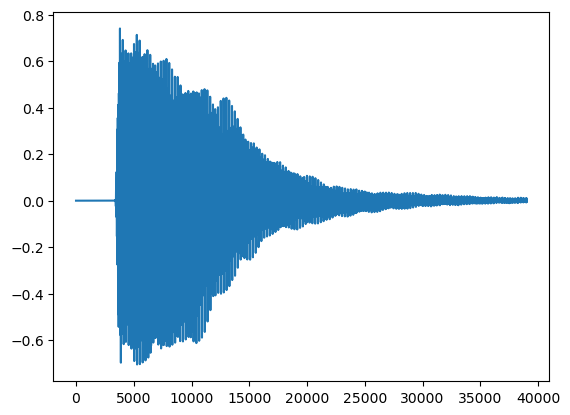

In [3]:
# sampling_rate
import tensorflow as tf
import tensorflow_io as tfio
import librosa as lb
chord_path = os.path.join(DATAPATH, 'C')
random_file = random.sample(os.listdir(chord_path), 1)[0]
file_path = os.path.join(chord_path, random_file)
wav, sr = lb.load(file_path, sr = 16000)
plt.plot(wav);

In [4]:
from IPython.display import Audio
Audio(wav, rate = 16000)

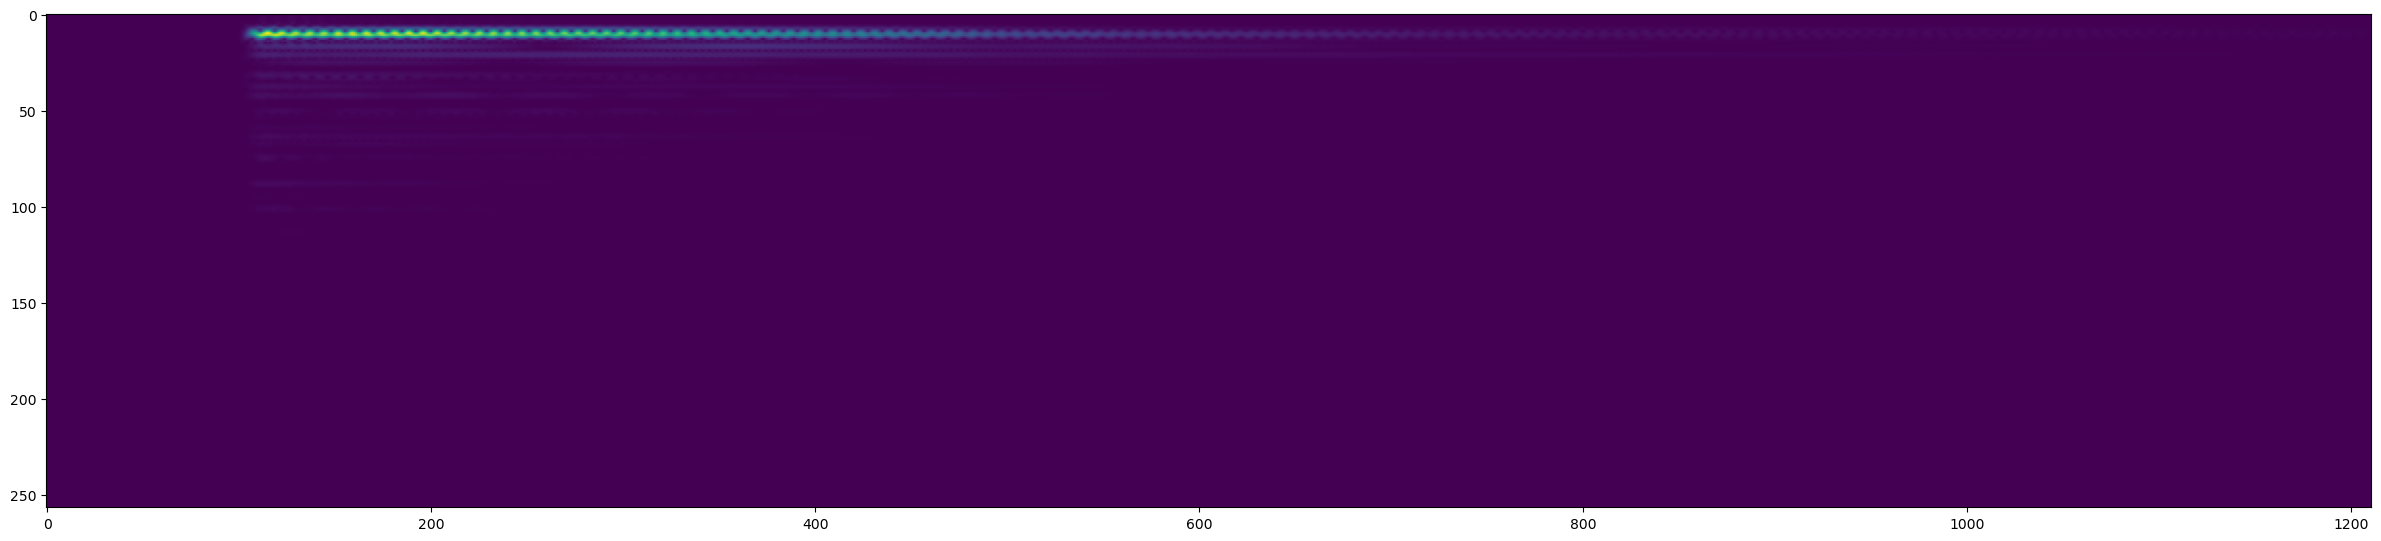

In [5]:
wav = tf.constant(wav)
spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram, axis = 2)
plt.figure(figsize = (30,20))
plt.imshow(tf.transpose(spectrogram)[0])

In [6]:
file_path

'dataset_chords\\C\\c34.wav'

In [7]:
len(wav)/sr, len(wav)

(2.44, 39040)

In [8]:
# let's create some function to load image and to convert into spectrogram and also a preprocessing function to also help wo this on dataset
def load_wav_file(filepath, waveform = True, name = "Audio file"): 
    """
    This function will load the audio file into 16Khz sampling rate
    
    returns wav file in tensorflow format
    """
    wav, rate = lb.load(filepath, sr = 16000)
    wav = tf.constant(wav)
    if waveform: 
        plt.plot(wav, label= name)
        plt.legend()
        plt.show()
    return wav

def convert_wav_to_spectrogram(wav,name = "Spectrogram",show = True, frame_length = 320, frame_step = 32, average_length = 35000):
    """
    convert tensorflow formated wav file to spectrogram of desired framelenght and fram steps
    
    also convert them to a average length and if not them add padding to them
    
    and returns spectrogram with mono channel
    """
    wav = wav[:average_length]
    #add zero padding at end
    zero_padding = tf.zeros([average_length] - tf.shape(wav), dtype = tf.float32)
    # concate that to audio file at end
    wav = tf.concat([wav, zero_padding], 0)
    # Create spectrogram of wavefrom file
    spectrogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
    #convert to absolute form
    spectrogram = abs(spectrogram)
    #Expand dims for adding channel (mono audio) 1
    spectrogram = tf.expand_dims(spectrogram, axis = 2)
    if show:
        plt.figure(figsize = (30, 20))
        plt.imshow(tf.transpose(spectrogram)[0])
        plt.title(name)
        plt.show()
    return spectrogram

def preprocessing(filepath, labels): 
    wav = load_wav_file(filepath, waveform=False)
    spectrogram = convert_wav_to_spectrogram(wav,show=False)
    return spectrogram, labels

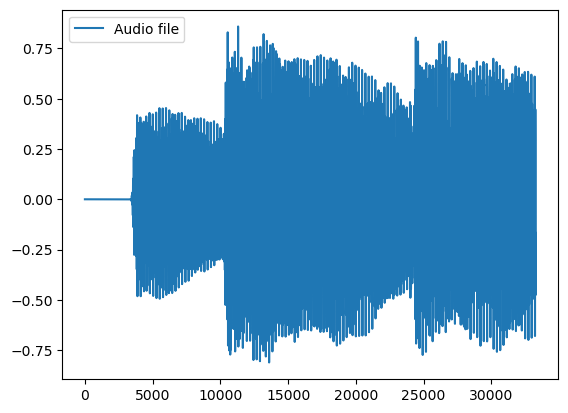

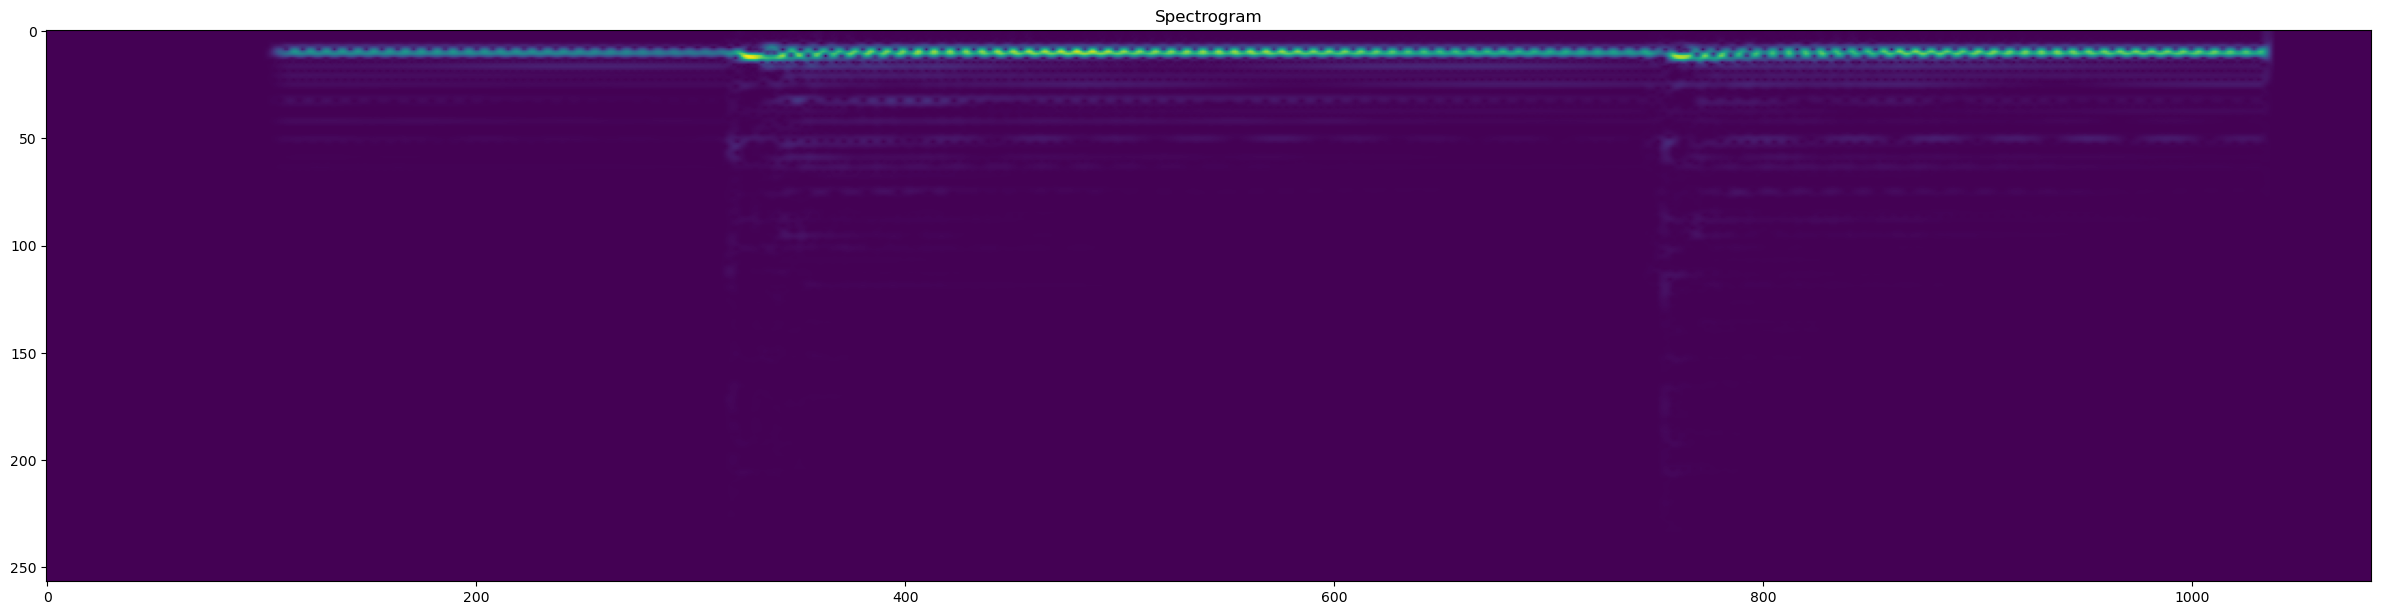

In [9]:
wav = load_wav_file('dataset_chords\\C\\c07.wav')
spectrogram = convert_wav_to_spectrogram(wav)

-------------------------------
For A Chord
Waveform of file : a24.wav


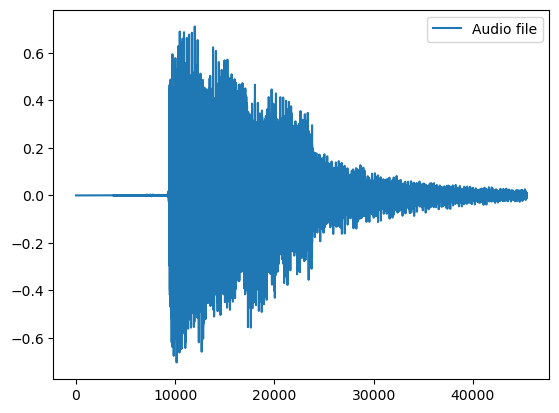

Spectrogram of file: a24.wav


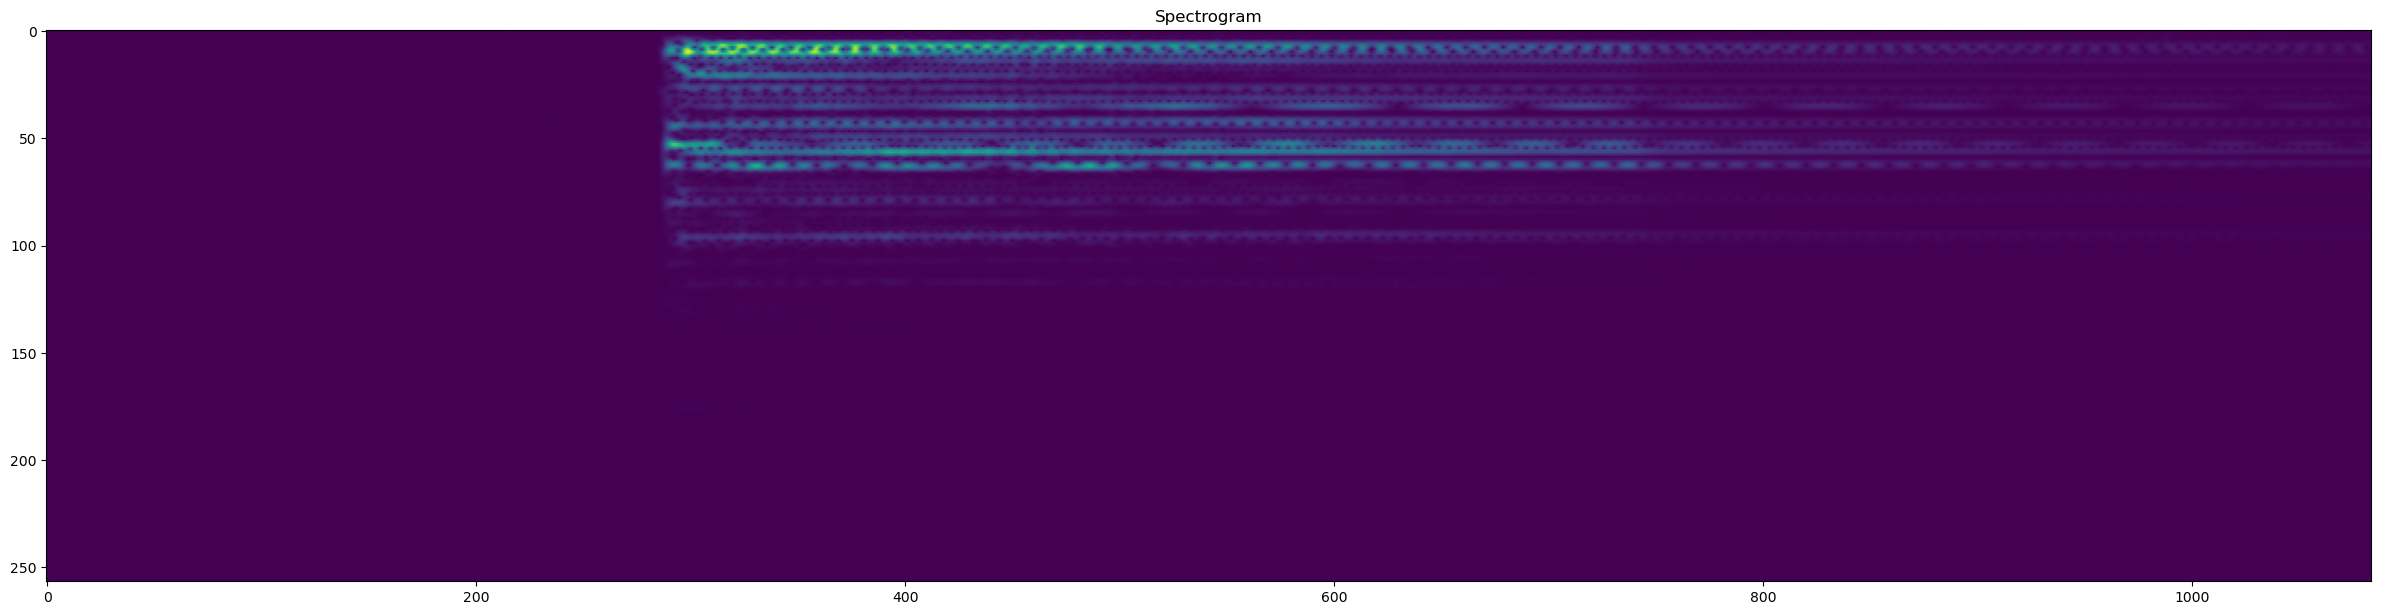

-------------------------------
For C Chord
Waveform of file : c89.wav


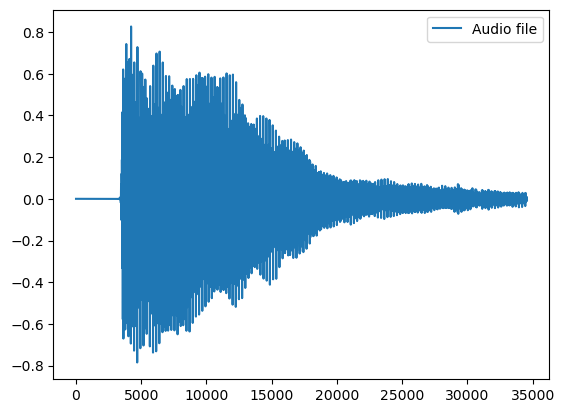

Spectrogram of file: c89.wav


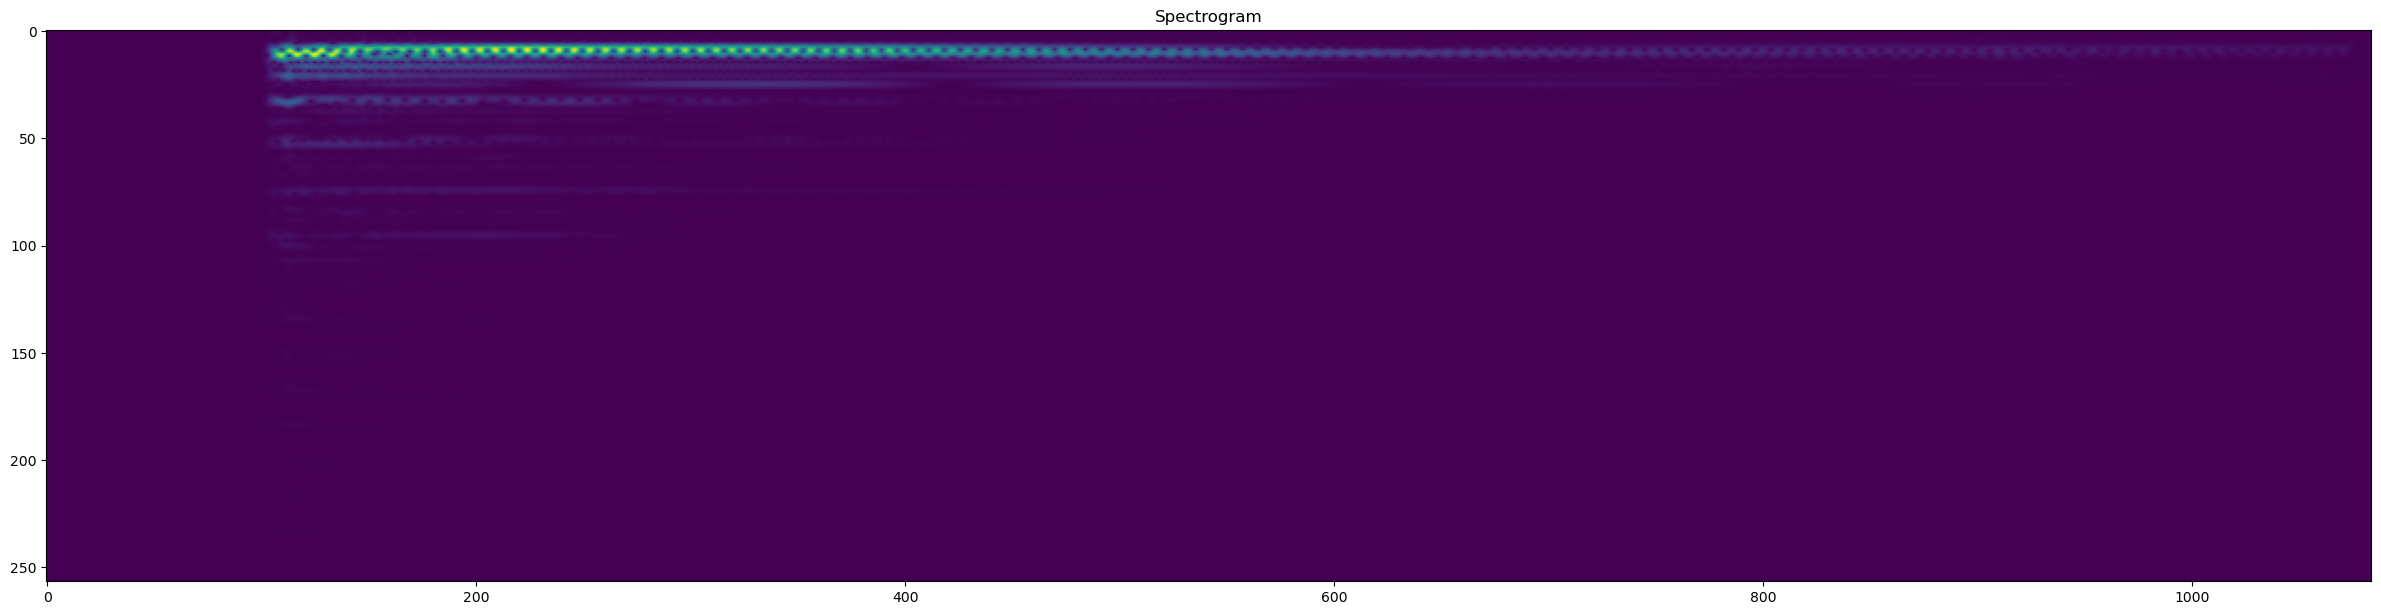

-------------------------------
For F Chord
Waveform of file : f25.wav


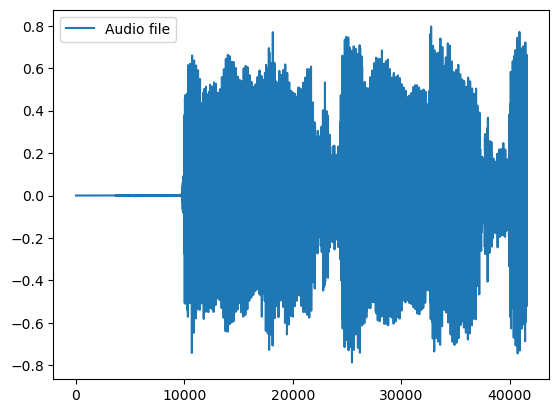

Spectrogram of file: f25.wav


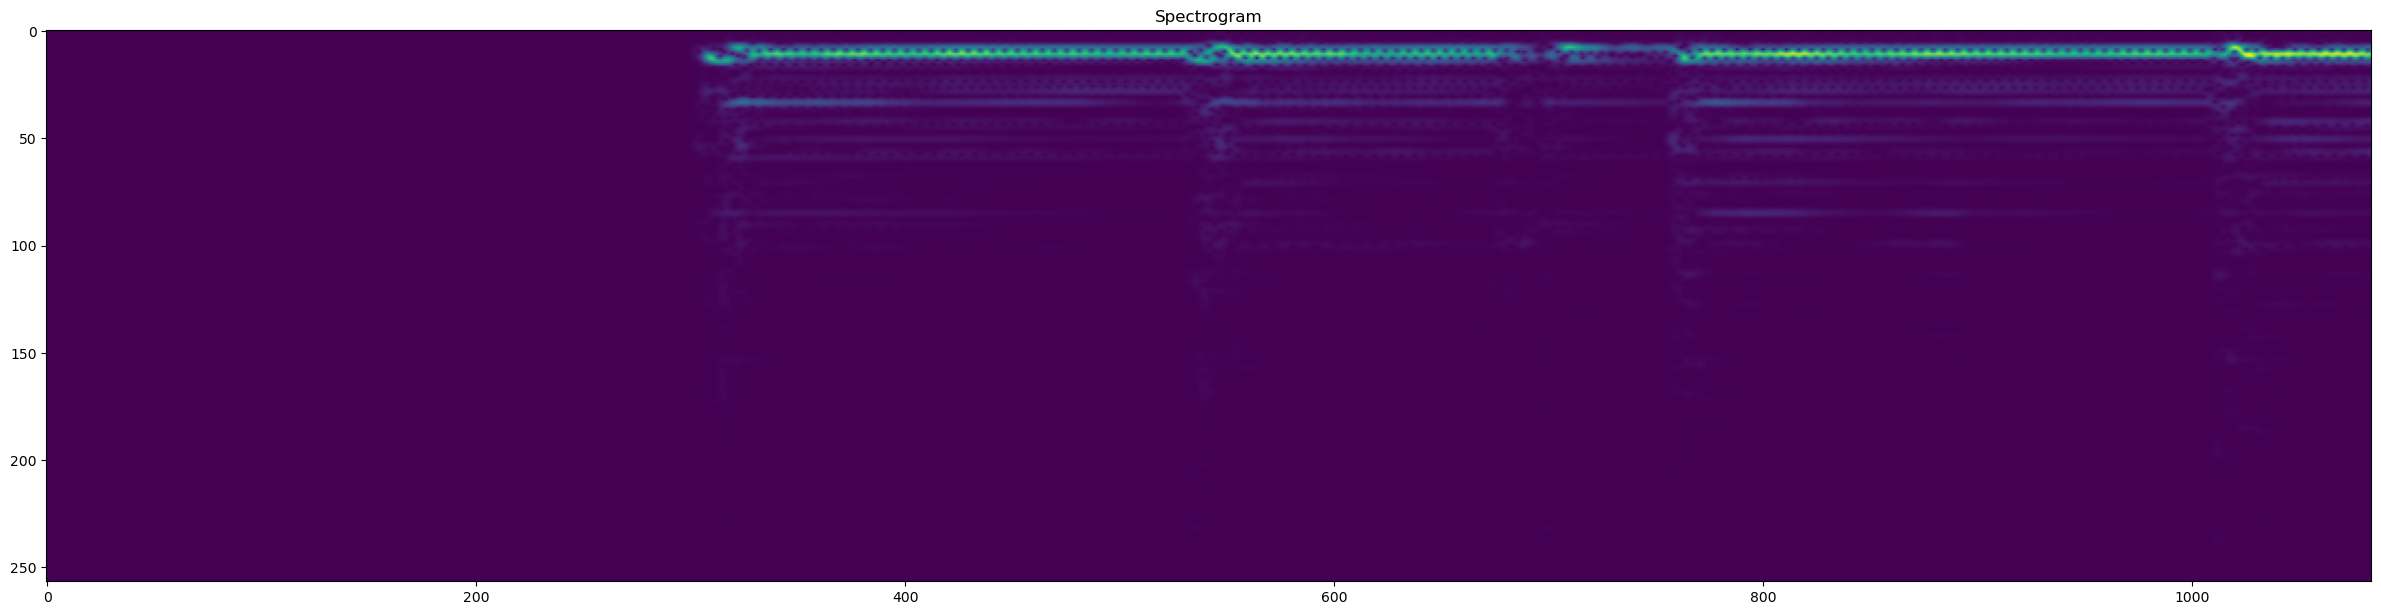

In [10]:
# Let's try to listen random files from all three directories
from IPython.display import Audio

for chord in os.listdir(DATAPATH): 
    chord_path = os.path.join(DATAPATH, chord)
    random_file = random.sample(os.listdir(chord_path), 1)[0]
    print(f"-------------------------------\nFor {chord} Chord")
    file_path = os.path.join(chord_path, random_file)
    print(f"Waveform of file : {random_file}")
    wav = load_wav_file(file_path)
    print(f"Spectrogram of file: {random_file}")
    spectrogram = convert_wav_to_spectrogram(wav)

## Create Tensorflow dataset

In [11]:
label = 0
for chord in os.listdir(DATAPATH): 
    chord_path = os.path.join(DATAPATH, chord)
    chord_data = tf.data.Dataset.list_files(chord_path+"/*.wav")
    labels = tf.data.Dataset.from_tensor_slices(tf.constant([label for i in range(len(chord_data))]))
    if label == 0: 
        data = tf.data.Dataset.zip((chord_data,labels))
    else: 
        data = data.concatenate(tf.data.Dataset.zip((chord_data, labels)))
    label+=1
    

In [12]:
data.shuffle(len(data)).as_numpy_iterator().next()

(b'dataset_chords\\C\\c57.wav', 1)

## Determine the average length of audio file to get the most appropriate cut

In [13]:
lengths = []
for chord in os.listdir(DATAPATH): 
    for file in os.listdir(os.path.join(DATAPATH, chord)): 
        wav = load_wav_file(os.path.join(DATAPATH, chord, file), waveform = False)
        lengths.append(len(wav))

In [14]:
lengths[:10]

[28160, 32000, 34560, 50560, 30720, 43520, 32000, 37760, 40960, 39680]

### Calculate min max and average

In [15]:
mean = tf.reduce_mean(lengths).numpy()
mean

35187

In [16]:
max = tf.reduce_max(lengths).numpy()
max

75520

In [17]:
min = tf.reduce_min(lengths).numpy()
min

22400

In [18]:
import numpy as np
lengths.sort()
median = lengths[len(lengths)//2]
median    

34560

#### 35000 is a good number for average content

In [19]:
RATE = 16000
print(f"Average length of Audio files: {mean/RATE :.2f}s")
print(f"Maximum length of Audio files: {max/RATE}s")
print(f"Minimum length of Audio files: {min/RATE}s")

Average length of Audio files: 2.20s
Maximum length of Audio files: 4.72s
Minimum length of Audio files: 1.4s


In [20]:
filepath, label = data.shuffle(len(data)).as_numpy_iterator().next()
spectrogram ,label = preprocessing(filepath, label)

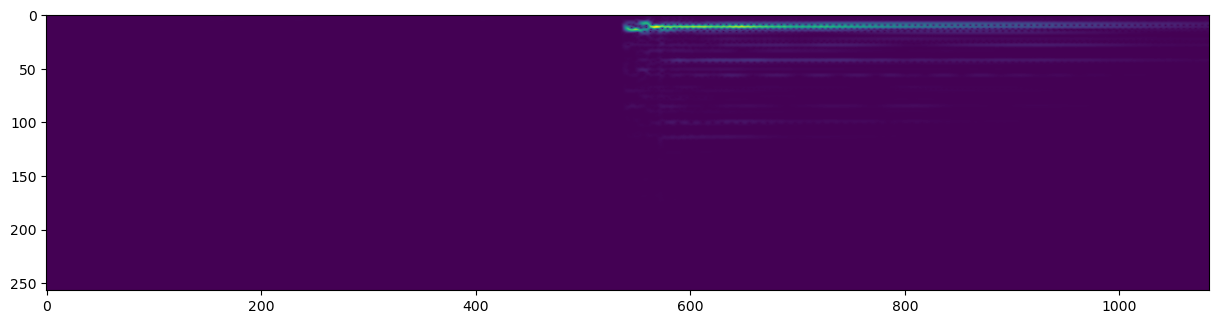

In [21]:
plt.figure(figsize = (15, 7))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

**This all is working like a Charm**

Let's try to train at mode and see how it goes

## Load all data

In [22]:
label = 0
for chord in os.listdir(DATAPATH): 
    chord_path = os.path.join(DATAPATH, chord)
    chord_data = []
    for file in os.listdir(chord_path): 
        wav = load_wav_file(os.path.join(chord_path, file), waveform=False)
        spectrogram = convert_wav_to_spectrogram(wav, show = False)
        chord_data.append(spectrogram)
    labels = tf.data.Dataset.from_tensor_slices(tf.constant([label for i in range(len(chord_data))]))
    chord_data = tf.data.Dataset.from_tensor_slices(chord_data)
    if label == 0: 
        data = tf.data.Dataset.zip((chord_data, labels))
    else: 
        data = data.concatenate(tf.data.Dataset.zip((chord_data, labels)))
    label+=1
    

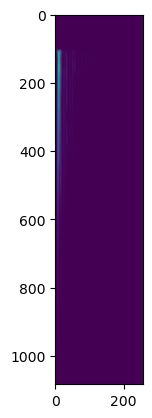

In [23]:
spectrogarm , label = data.shuffle(len(data)).as_numpy_iterator().next()
plt.imshow(spectrogram), label;

In [24]:
len(data)

312

## Create data batchs

In [25]:
batch_size = 32
data = data.shuffle(len(data)).batch(batch_size)

In [26]:
data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 1084, 257, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [27]:
len(data)

10

In [28]:
# let's use one batch for testing and other for training
Take = np.round(len(data)* 0.8)
train = data.take(Take)
test = data.skip(Take).take(len(data) - Take)

In [29]:
len(train)

8

In [30]:
len(test)

2

## Test one batch

In [31]:
samples , labels = train.as_numpy_iterator().next()

In [32]:
samples.shape

(32, 1084, 257, 1)

In [33]:
labels

array([1, 1, 0, 2, 0, 1, 0, 0, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0, 0, 1, 1, 1,
       0, 0, 2, 2, 1, 0, 2, 2, 2, 0])

## Build Deep learning model

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D

In [40]:
model = Sequential([
    Conv2D(32, 3, activation = 'relu', input_shape = (1084, 257, 1)),
    Conv2D(32, 3, activation = 'relu', padding='same'),
    MaxPool2D(pool_size = 2),
    Conv2D(16, 3, activation = 'relu', padding = 'same'),
    Conv2D(16, 3, activation = 'relu', padding = 'same'),
    MaxPool2D(),
    Conv2D(10, 3, activation = 'relu', padding = 'valid'),
    Conv2D(10, 3, activation = 'relu', padding = 'valid'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation = 'relu'),
    Dense(len(os.listdir(DATAPATH)), activation = 'softmax')
])
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 1082, 255, 32)     320       
                                                                 
 conv2d_31 (Conv2D)          (None, 1082, 255, 32)     9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 541, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 541, 127, 16)      4624      
                                                                 
 conv2d_33 (Conv2D)          (None, 541, 127, 16)      2320      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 270, 63, 16)       0         
 ng2D)                                                

In [42]:
history = model.fit(train,
                    epochs = 5,
                    validation_data = test)

Epoch 1/5
8/8 [==============================] - 82s 10s/step - loss: 1.0343 - accuracy: 0.4688 - val_loss: 0.7816 - val_accuracy: 0.6071
Epoch 2/5
8/8 [==============================] - 73s 9s/step - loss: 0.8372 - accuracy: 0.5781 - val_loss: 0.6246 - val_accuracy: 0.7321
Epoch 3/5
8/8 [==============================] - 72s 9s/step - loss: 0.5411 - accuracy: 0.7891 - val_loss: 0.3736 - val_accuracy: 0.9107
Epoch 4/5
8/8 [==============================] - 70s 9s/step - loss: 0.3320 - accuracy: 0.8945 - val_loss: 0.1758 - val_accuracy: 0.9643
Epoch 5/5
8/8 [==============================] - 72s 9s/step - loss: 0.1723 - accuracy: 0.9414 - val_loss: 0.1456 - val_accuracy: 0.9464


In [43]:
model.evaluate(test)

2/2 [==============================] - 3s 1s/step - loss: 0.0890 - accuracy: 0.9643


[0.08897282183170319, 0.9642857313156128]

In [44]:
sample, label = test.as_numpy_iterator().next()
pred = model.predict(sample)

1/1 [==============================] - 2s 2s/step


In [72]:
pred

array([[6.4788692e-02, 5.5198628e-02, 8.8001263e-01],
       [4.5496151e-08, 2.7056089e-07, 9.9999964e-01],
       [9.7880143e-01, 1.7352151e-02, 3.8464696e-03],
       [9.6460110e-01, 7.1015995e-04, 3.4688696e-02],
       [1.3767458e-04, 9.9986231e-01, 9.7719499e-11],
       [9.0156829e-01, 6.6287093e-02, 3.2144591e-02],
       [1.5194288e-01, 8.0338103e-01, 4.4676054e-02],
       [3.4853143e-03, 9.9344629e-01, 3.0683773e-03],
       [7.5959147e-06, 9.9999237e-01, 3.2369446e-10],
       [7.3802850e-04, 9.9926180e-01, 8.3246114e-08],
       [9.2447400e-01, 5.4258984e-02, 2.1267012e-02],
       [1.4812276e-01, 9.7310662e-02, 7.5456661e-01],
       [2.8080810e-03, 9.9718082e-01, 1.1130016e-05],
       [3.0941464e-04, 8.1161859e-05, 9.9960941e-01],
       [1.3729812e-07, 2.8695055e-08, 9.9999988e-01],
       [2.4715402e-07, 9.9999976e-01, 8.2937462e-10],
       [9.5739120e-01, 4.1354753e-02, 1.2540604e-03],
       [9.0462861e-05, 9.2696620e-04, 9.9898249e-01],
       [5.9702402e-01, 1.854

In [110]:
np.argmax(pred, axis = 1)

array([2, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1,
       0, 1, 2, 1, 0, 2, 2, 2, 2, 2], dtype=int64)

In [49]:
label

array([2, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1,
       0, 1, 2, 1, 0, 2, 2, 2, 2, 2])

## Visualize model Training

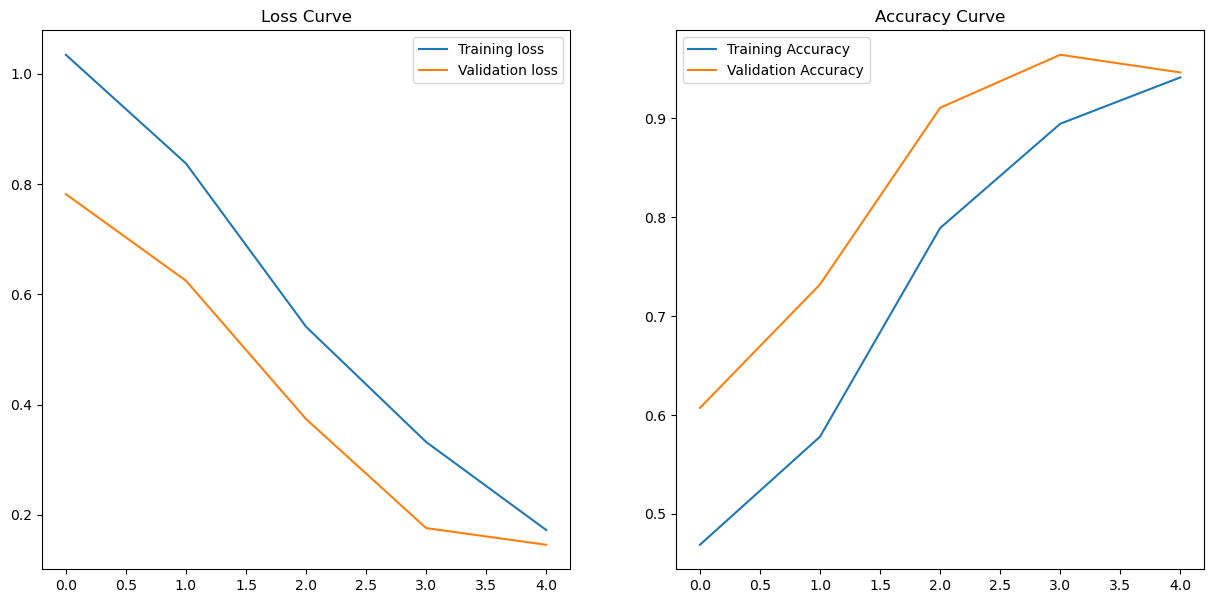

In [64]:
# Let's build loss and accuracy curve seperately

fig, ax = plt.subplots(1, 2,figsize =(15, 7))
History = pd.DataFrame(history.history)
ax[0].plot(History["loss"], label = "Training loss");
ax[0].plot(History['val_loss'], label = "Validation loss");
ax[0].set(title = "Loss Curve")
ax[0].legend();
ax[1].plot(History["accuracy"], label = "Training Accuracy");
ax[1].plot(History['val_accuracy'], label = "Validation Accuracy");
ax[1].set(title = "Accuracy Curve")
ax[1].legend();

In [124]:
# Create function to convert prediction to labels
def convert_pred_label(y_pred): 
    y_pred = np.argmax(y_pred, axis = 1)
    labels = os.listdir(DATAPATH)
    results = [[labels[x]] for x in y_pred]
    return np.array(results)
def show_label_with_pred_prob(y_pred): 
    chords = convert_pred_label(y_pred)
    label_index = np.argmax(y_pred, axis = 1)
    pred_prob = np.array([[y_pred[i][label_index[i]]] for i in range(len(y_pred))])
    result = np.hstack((chords, pred_prob))
    return result
def convert_prob_label_index(y_pred): 
    return np.argmax(y_pred, axis = 1)

In [125]:
show_label_with_pred_prob(pred)

array([['F', '0.88001263'],
       ['F', '0.99999964'],
       ['A', '0.9788014'],
       ['A', '0.9646011'],
       ['C', '0.9998623'],
       ['A', '0.9015683'],
       ['C', '0.803381'],
       ['C', '0.9934463'],
       ['C', '0.9999924'],
       ['C', '0.9992618'],
       ['A', '0.924474'],
       ['F', '0.7545666'],
       ['C', '0.9971808'],
       ['F', '0.9996094'],
       ['F', '0.9999999'],
       ['C', '0.99999976'],
       ['A', '0.9573912'],
       ['F', '0.9989825'],
       ['A', '0.597024'],
       ['A', '0.9993813'],
       ['A', '0.7709351'],
       ['C', '0.9874315'],
       ['A', '0.9999801'],
       ['C', '0.97988164'],
       ['F', '0.9999676'],
       ['C', '0.8926575'],
       ['A', '0.5364448'],
       ['F', '0.99964976'],
       ['F', '0.99997246'],
       ['F', '0.9999999'],
       ['F', '0.80628246'],
       ['F', '0.7035051']], dtype='<U32')

In [126]:
convert_pred_label(pred)[:,-1]

array(['F', 'F', 'A', 'A', 'C', 'A', 'C', 'C', 'C', 'C', 'A', 'F', 'C',
       'F', 'F', 'C', 'A', 'F', 'A', 'A', 'A', 'C', 'A', 'C', 'F', 'C',
       'A', 'F', 'F', 'F', 'F', 'F'], dtype='<U1')

In [127]:
convert_prob_label_index(pred)

array([2, 2, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1,
       0, 1, 2, 1, 0, 2, 2, 2, 2, 2], dtype=int64)

## Let's try to make predictions on custom data

In [146]:
def make_pred_custom_chord(filepath, model): 
    wav = load_wav_file(filepath)
    spectrogram = convert_wav_to_spectrogram(wav)
    pred = model.predict(tf.expand_dims(spectrogram, axis = 0))
    return show_label_with_pred_prob(pred)

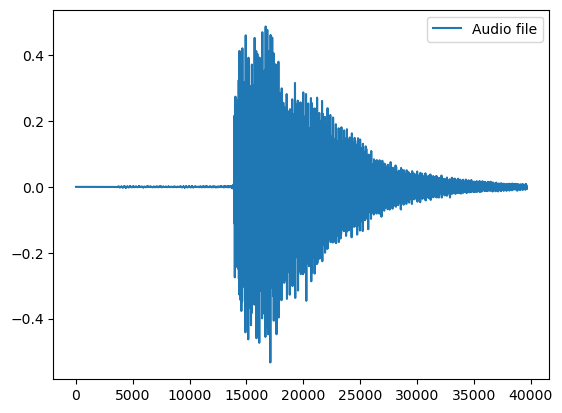

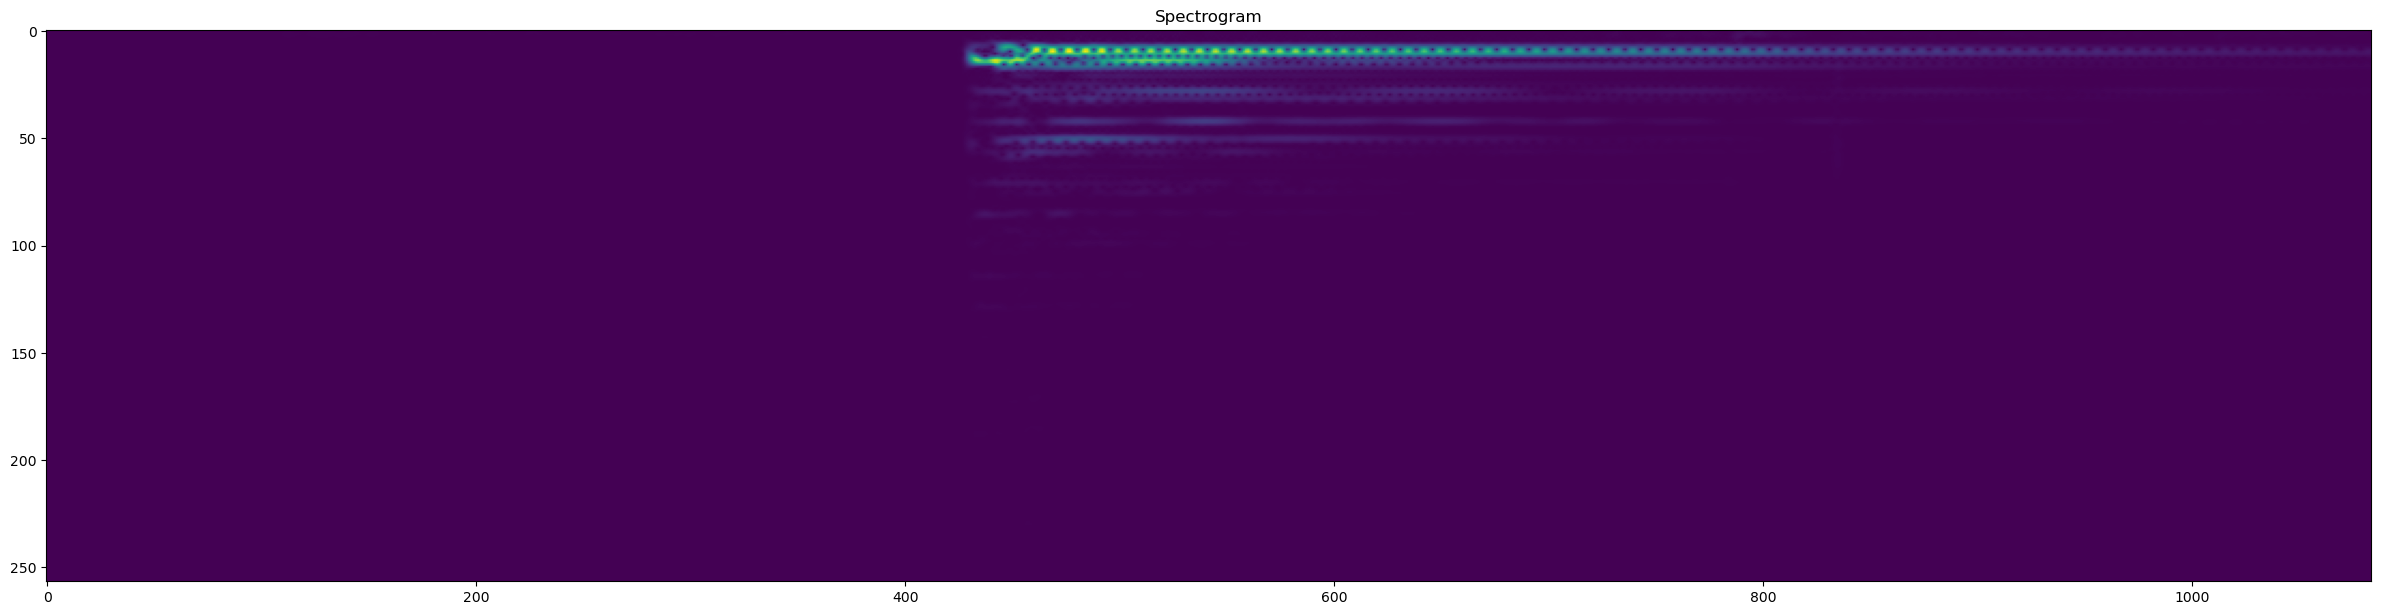

1/1 [==============================] - 0s 104ms/step


array([['A', '0.895862']], dtype='<U32')

In [147]:
make_pred_custom_chord(r"C:\Mitsgwl\sem 5\Minor_project\dataset_chords\A\a94.wav", model = model)

In [141]:
# Save the model 
save_path = "C:/Mitsgwl/sem 5/Minor_project/models/Classifier_ACF.keras"
model.save(save_path)

In [142]:
# laod model 
def load_model(path): 
    return tf.keras.saving.load_model(path)

In [143]:
loaded_model = load_model(save_path)

In [145]:
loaded_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 1082, 255, 32)     320       
                                                                 
 conv2d_31 (Conv2D)          (None, 1082, 255, 32)     9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 541, 127, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_32 (Conv2D)          (None, 541, 127, 16)      4624      
                                                                 
 conv2d_33 (Conv2D)          (None, 541, 127, 16)      2320      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 270, 63, 16)       0         
 ng2D)                                                

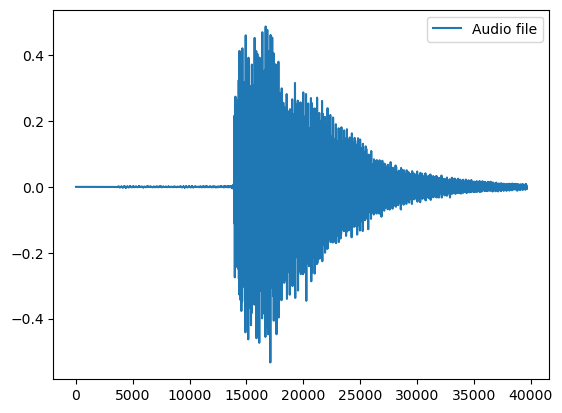

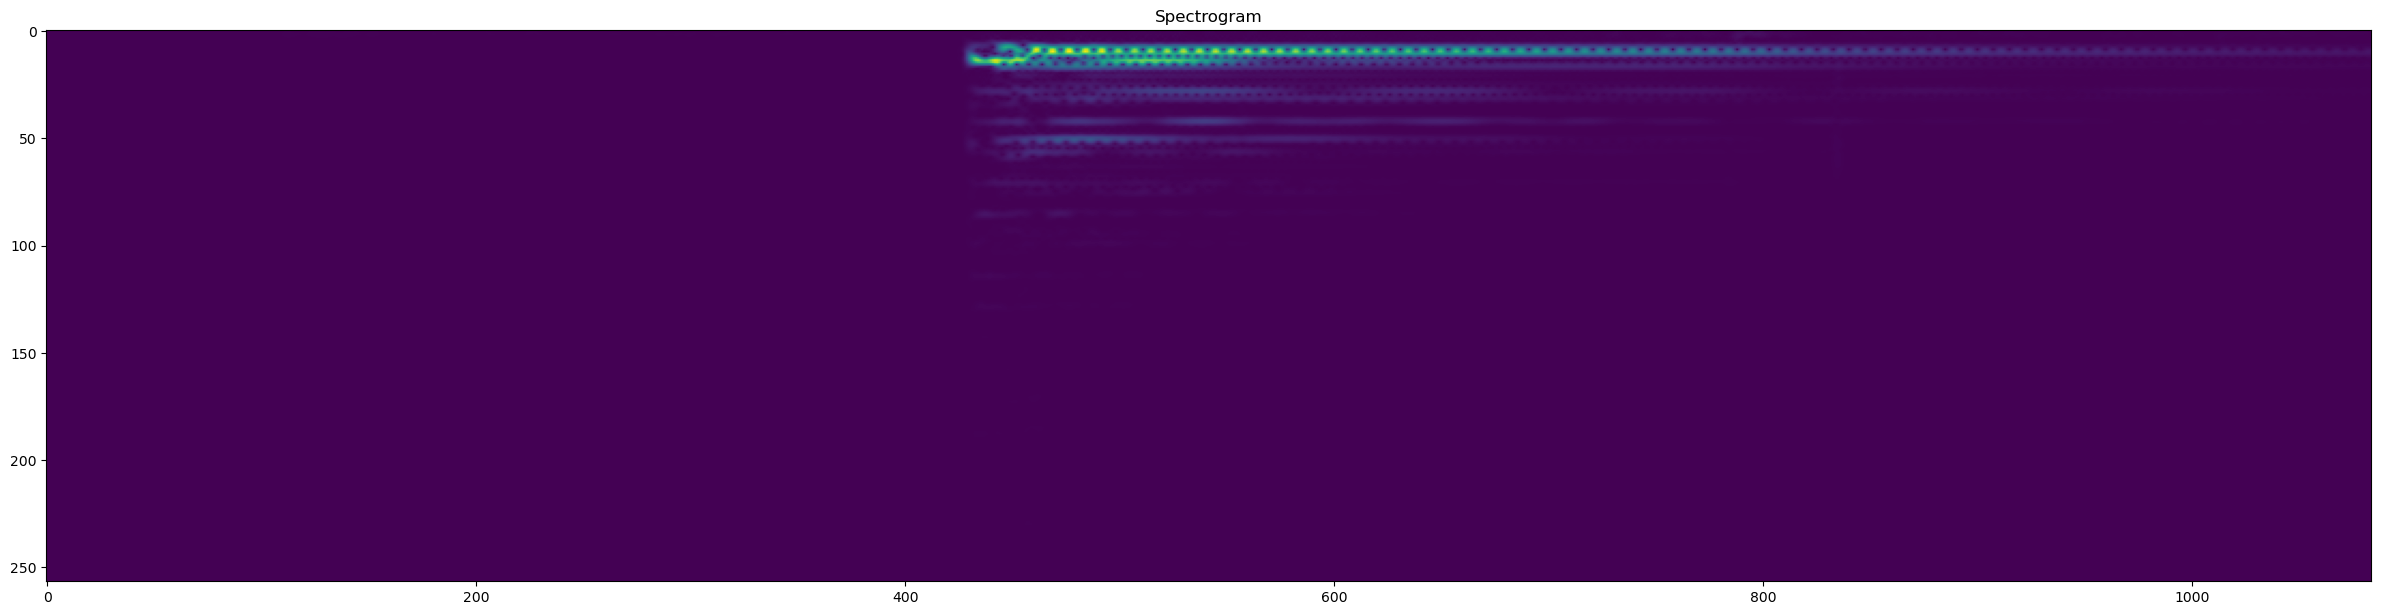

1/1 [==============================] - 0s 187ms/step


array([['A', '0.895862']], dtype='<U32')

In [149]:
make_pred_custom_chord("dataset_chords/A/a94.wav", model =loaded_model)

In [151]:
wav = load_wav_file("dataset_chords/A/a94.wav", waveform=False)
Audio(wav, rate = 16000)

let's try the prediction on the mp3 file also 

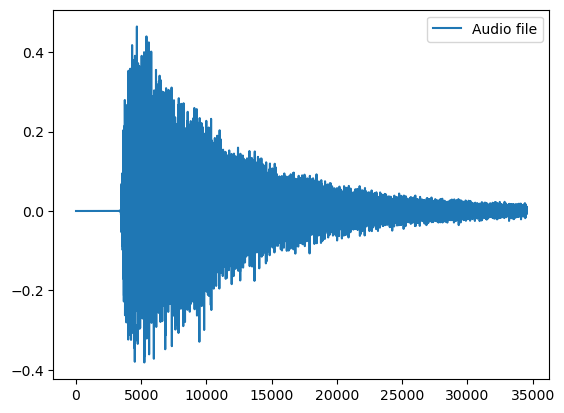

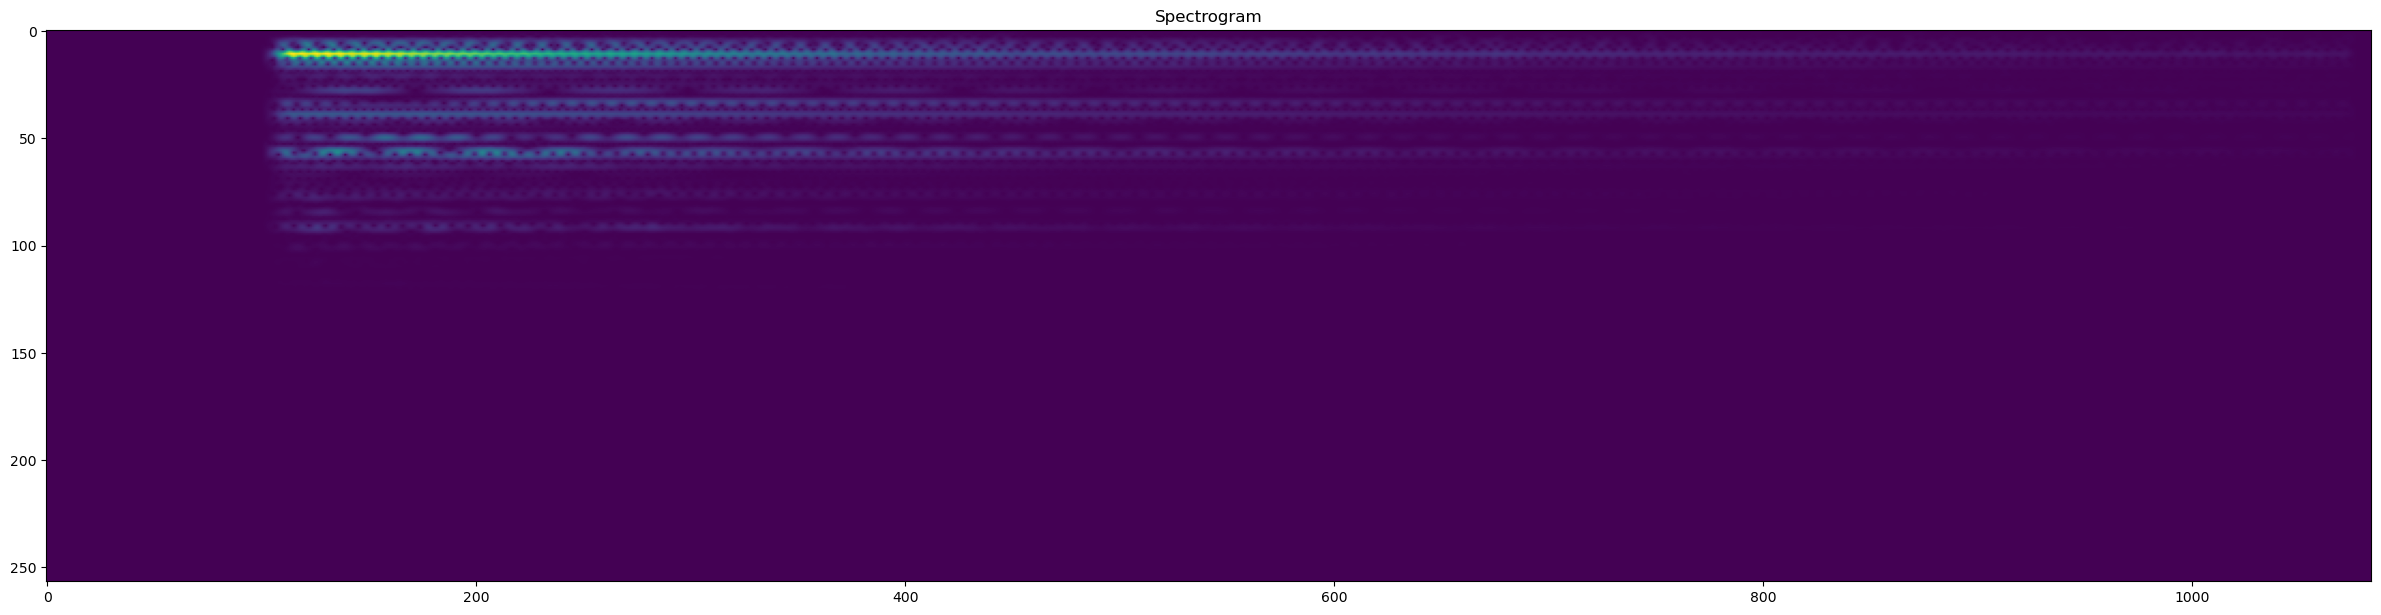

1/1 [==============================] - 0s 73ms/step


array([['F', '0.99424547']], dtype='<U32')

In [152]:
make_pred_custom_chord("f47.mp3", loaded_model)

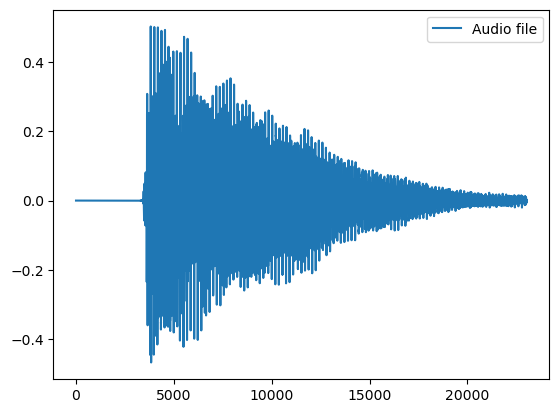

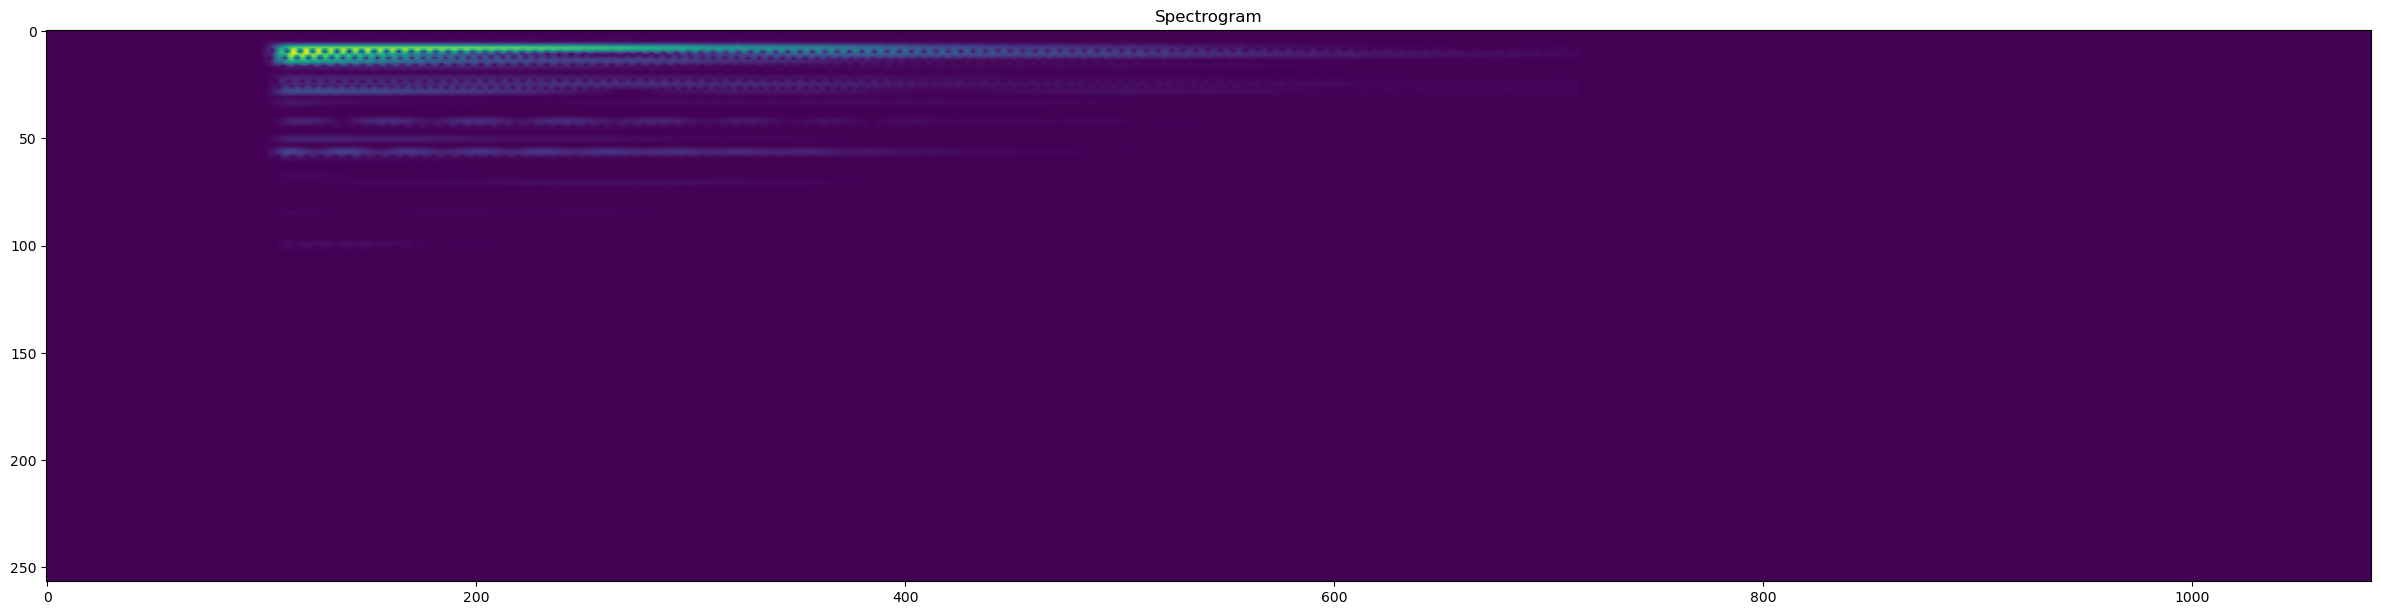

1/1 [==============================] - 0s 77ms/step


array([['F', '0.9846827']], dtype='<U32')

In [155]:
make_pred_custom_chord("dataset_chords/F/f04.wav", loaded_model)

I want to make prediction on a bigger mp3 file by spliting and making predictions through sliding window method

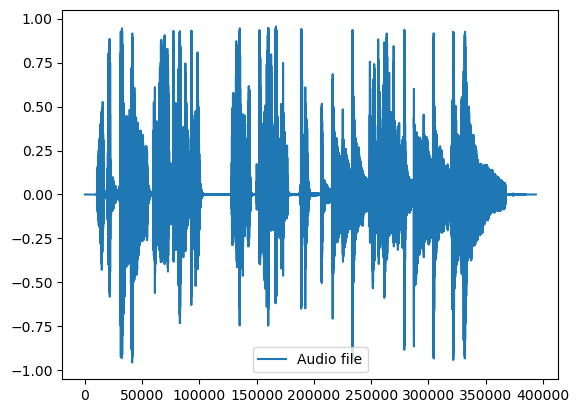

In [156]:
# let's take a look how that file looks
wav = load_wav_file("F_chord_test.mp3")
Audio(wav, rate = 16000)

In [157]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, 
                                                               sequence_length=35000, 
                                                               sequence_stride=35000,
                                                               batch_size=1)

In [158]:
len(audio_slices)

11

In [159]:
sample = audio_slices.as_numpy_iterator().next()

In [162]:
Audio(sample[0], rate = 16000)

In [165]:
audio_slices

<_BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [185]:
slices = []
for sample in audio_slices.as_numpy_iterator():
    slices.append(tf.expand_dims(convert_wav_to_spectrogram(sample[0][0], show = False),axis  =0 ))

In [186]:
slices = tf.data.Dataset.from_tensor_slices(slices)

In [187]:
slices.batch(32)

<_BatchDataset element_spec=TensorSpec(shape=(None, 1, 1084, 257, 1), dtype=tf.float32, name=None)>

In [188]:
len(slices)

11

In [189]:
pred = model.predict(slices)

11/11 [==============================] - 1s 60ms/step


In [190]:
np.argmax(pred,axis = 1)

array([0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1], dtype=int64)

In [192]:
# let's load the mp3 audio file and split it into files of 35000 length
def load_mp3_slited_files(path): 
    wav = load_wav_file(path, waveform=False)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, 
                                                               sequence_length=35000, 
                                                               sequence_stride=35000,
                                                               batch_size=1)
    slices = []
    for sample in audio_slices.as_numpy_iterator():
        slices.append(tf.expand_dims(convert_wav_to_spectrogram(sample[0][0], show = False),axis  =0 ))
    slices = tf.data.Dataset.from_tensor_slices(slices)
    slices.batch(len(audio_slices))
    return slices

In [193]:
f_chords = load_mp3_slited_files("F_chord_test.mp3")

In [196]:
convert_pred_label(model.predict(f_chords))[:, -1]

11/11 [==============================] - 1s 62ms/step


array(['A', 'A', 'F', 'F', 'F', 'A', 'A', 'A', 'A', 'A', 'C'], dtype='<U1')